# DSCI 100 - Report
### project-003-7: Nicole Campbell, Michelle Kim, Jason Liu, Zahra Raza

## Introduction

Our project is centred around the question, does study time influence student grades? We want to discover the relationship between a student's grades and study time. This topic is particularly fascinating as it is common practice for instructors to suggest higher study time anytime there is an examination and a generous amount throughout the semester; so does this practice reign true? According to multiple articles and studies, proper study time is the key to successful grades (Oxford Learning, 2018), however, sometimes that is not the case for some students and the study time-grade relationship may be spurious (Olivares, 2002). Through this project, we wish to further clarify the debate of study time and grades using the data from two different Portuguese schools. 

We will be working with the “Student Performance” data set, collected by Paulo Cortez at the University of Minho. The data set contains information gathered from students at two different Portuguese secondary schools. The information collected includes student grades, social and study habits, study time, and family background. The data set also tracks first-period, second-period, and final grades in Mathematics on an integer scale from 0 to 20, 0 being the lowest possible grade and 20 being the highest. 

## Methods and Results

In [30]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(cowplot)
options(repr.matrix.max.rows = 6)

First, we loaded our data directly from the web (github). The origianal file includes both math and portuguese grades data as a separate csv files, but we only downloaded math grades data since we are only going to use math grades to predict students studytime.

As a part of wrangling and cleaning the data, we selected only the variables of interest out of 30 variables from the original data. 

1. studytime: weekly study time (numeric interval- **1**: 1 to <2 hours, **2**: 2 to <5 hours, **3**: 5 to <10 hours, **4**: >10 hours)
2. G1: first period grade (numeric value- from 0 to 20)
3. G2: second period grade (numeric value- from 0 to 20)
4. G3: final grade (numeric value- from 0 to 20)

Declared studytime as a factor since that is what we want to categorize students by their predicted study time based on their math grades.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Number of observations per class category"


studytime,n
<fct>,<int>
1,105
2,198
3,65
4,27


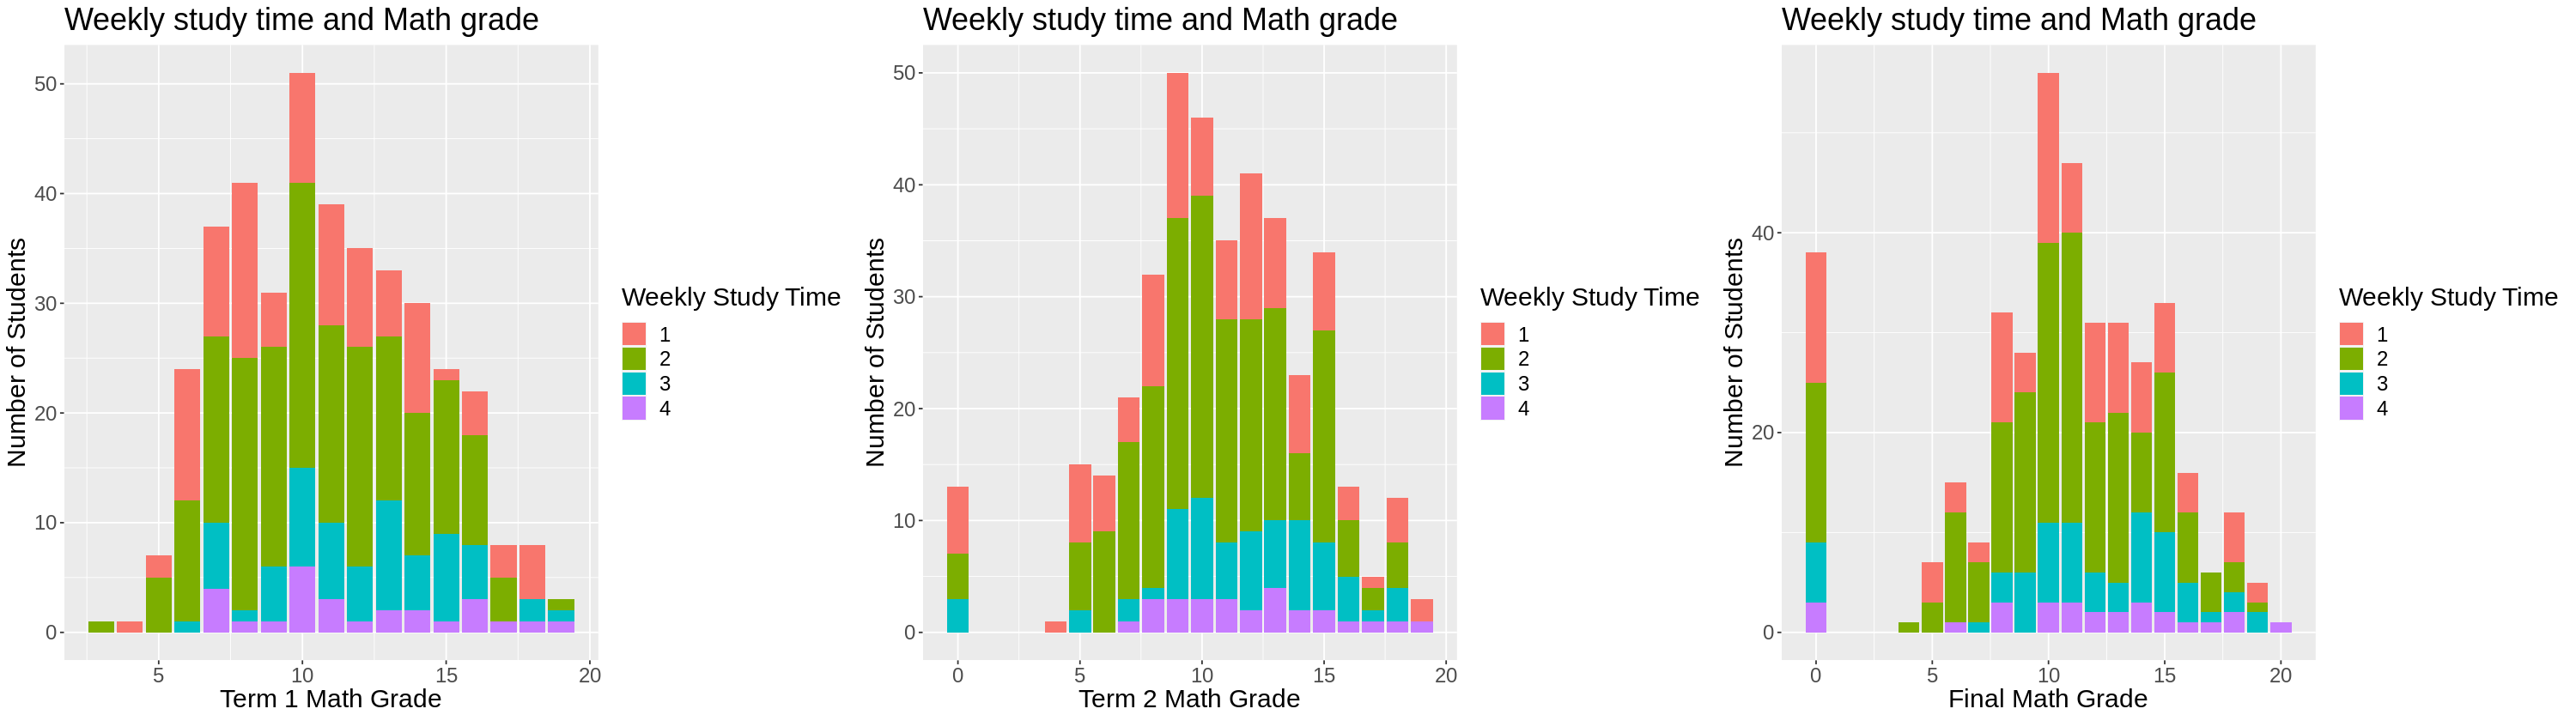

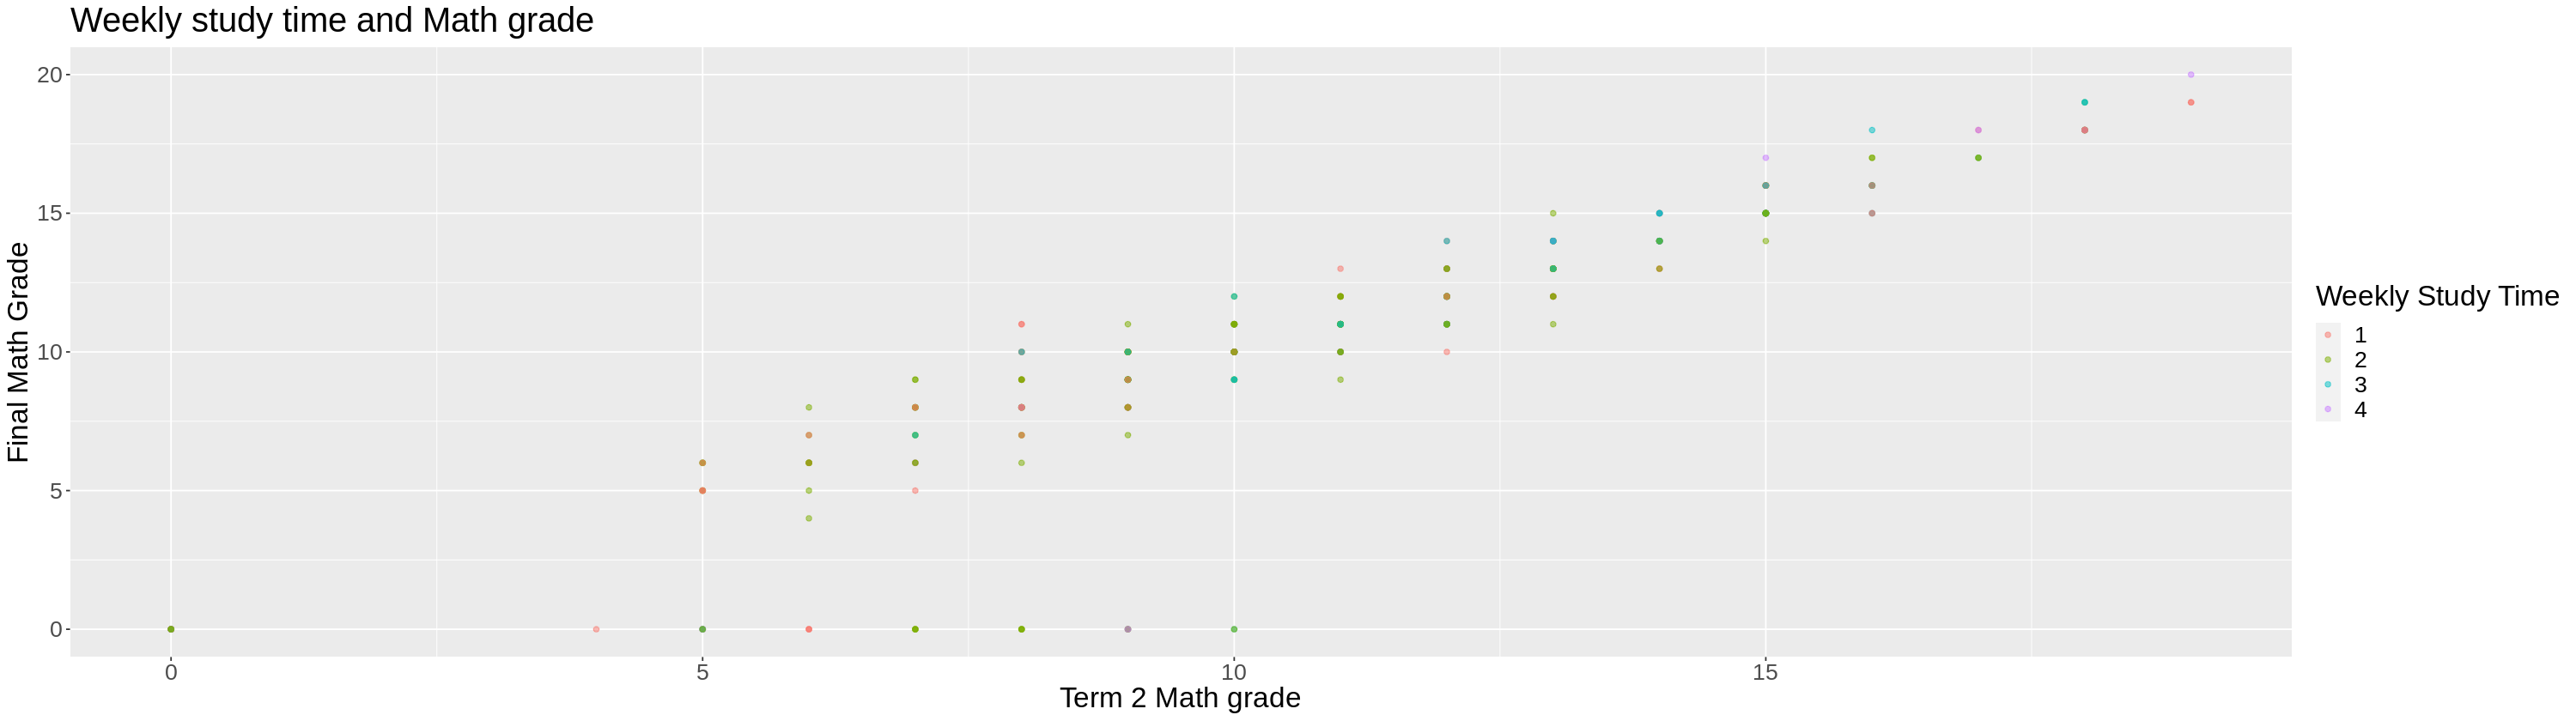

In [29]:
set.seed(300);

#Read data set from the web into R
student_mat <- read_delim("https://raw.githubusercontent.com/michelleykim/student_performance_analysis/main/data/student-mat.csv", delim = ";")

# Clean and wrangle data into tidy format
mat_select <- student_mat %>%
                select("studytime", "G1", "G2", "G3") %>%
                mutate(studytime = as_factor(studytime))

# number of observations in higher(target variable)
counts <- mat_select %>%
        group_by(studytime) %>%
        summarize(n=n())   
print('Number of observations per class category')
counts

mat_plot_1 <- mat_select %>%
                ggplot(aes(x=G1, y=studytime))+
                geom_bar(aes(y = ..count.., fill = studytime))+
                labs(x = "Term 1 Math Grade", y = "Number of Students", fill = "Weekly Study Time", 
                     title = "Weekly study time and Math grade")+
                theme(text = element_text(size=18))
mat_plot_2 <- mat_select %>%
                ggplot(aes(x=G2, y=studytime))+
                geom_bar(aes(y = ..count.., fill = studytime))+
                labs(x = "Term 2 Math Grade", y = "Number of Students", fill = "Weekly Study Time", 
                     title = "Weekly study time and Math grade")+
                theme(text = element_text(size=18))
mat_plot_3 <- mat_select %>%
                ggplot(aes(x=G3, y=studytime))+
                geom_bar(aes(y = ..count.., fill = studytime))+
                labs(x = "Final Math Grade", y = "Number of Students", fill = "Weekly Study Time", 
                     title = "Weekly study time and Math grade")+
                theme(text = element_text(size=18))

mat_scatter_plot <- mat_select %>%
                select(G2, G3, studytime) %>%
                ggplot(aes(x = G2, y = G3, colour = studytime)) + 
                geom_point(alpha = 0.5)+
                labs(x = "Term 2 Math grade", 
                     y = "Final Math Grade", 
                     colour = "Weekly Study Time", 
                     title = "Weekly study time and Math grade")+
                theme(text = element_text(size=20))  

options(repr.plot.width = 25, repr.plot.height = 7)
plot_grid(mat_plot_1, mat_plot_2, mat_plot_3, ncol = 3)

mat_scatter_plot

Then we split the wrangled data into training and testing sets. We used prop = 0.75 since the dataset in total has 395 students which is small enough that we will get reasonable amount of training and testing data with this split. 

We didn't scaled or centered the data since the original data was already scaled and centered by the institution. However, we overpopulated some datapoint using `step_upsample` to balance because the original dataset had significantly many students studying for 2 to <5 hours compared to other time intervals. 

For the K-NN classification, we decided to use 5-fold cross validation since we thought that using 5 validation sets would give us enough folding while not taking up too much time.

Then we plotted the accuracies for each choice of neighbours to choose the k value to predict the testing set. 

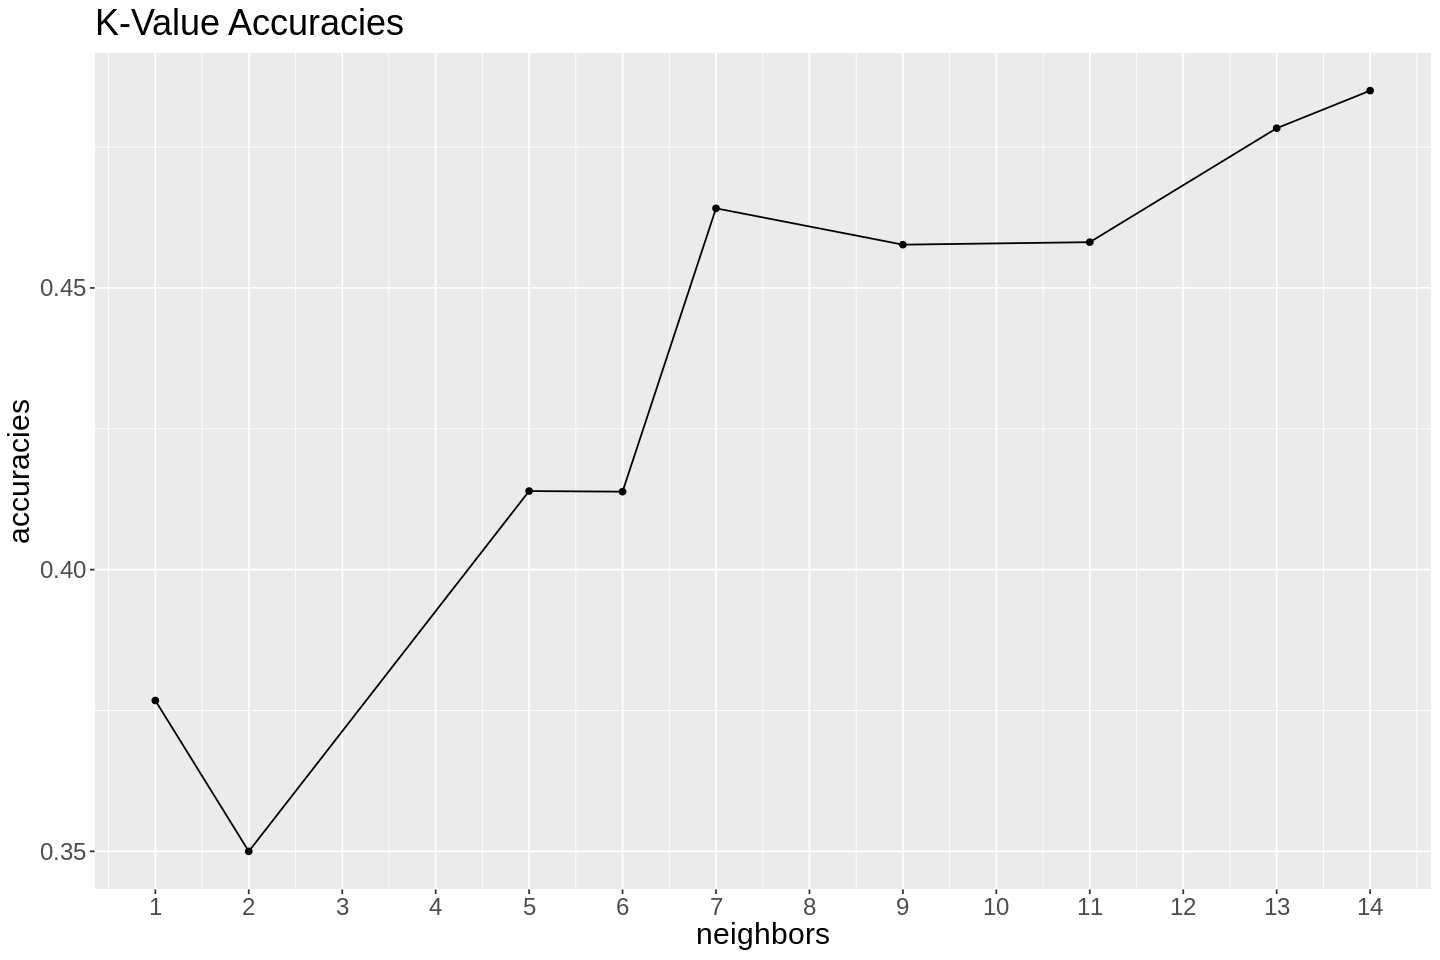

In [28]:
set.seed(300);

# Obtain training set:
# We chose prop= 0.75 since the data set is small enough that we will still 
# have a reasonable amount of training and testing data with this split.
mat_split <- initial_split(mat_select, prop = 0.75, strata = studytime) 
mat_train <- training(mat_split)
mat_test <- testing(mat_split)

# vfold_cv
mat_vfold <- vfold_cv(mat_train, v = 5, strata = studytime)

# balancing
mat_overpop_recipe <- recipe(studytime ~., data = mat_train) %>%
        step_upsample(studytime, over_ratio = 1, skip = FALSE) %>%
        prep()
mat_overpop <- bake(mat_overpop_recipe, mat_train)

#recipe
mat_recipe <- recipe(studytime ~., data = mat_overpop)

# nearest_neighbour
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
        set_engine("kknn") %>%
        set_mode("classification")

# workflow & tune_grid
knn_workflow <- workflow() %>%
        add_recipe(mat_recipe) %>%
        add_model(knn_spec) %>%
        tune_grid(resamples = mat_vfold, grid = 10) %>%
        collect_metrics()

# produce accuracy graph to determine the k value
accuracies <- knn_workflow %>%
        filter(.metric == "accuracy")
options(repr.plot.width = 12, repr.plot.height = 8)
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "neighbors", y = "accuracies", title = "K-Value Accuracies") +
        scale_x_continuous(breaks = seq(0, 15, by = 1)) +
        theme(text = element_text(size=18))  

cross_val_plot

Based on the cross validation graph, the nearest_neighbor algorithm give the highest accuracy when 14 neighbors were used for prediction. However, we decided to use k = 7, since we were worried that using 14 neighbors would cause underfitting with out small dataset. Also, since the difference in accuracies between using 7 neighbors and 14 neighbours is small, both choice are potentially the optimal accuracy. 

Using the K value determined from the graph, we predict the studytime of testing set data and found the accuracy.

In [24]:
set.seed(300);

# nearest_neighbour with k = 7, workflow 
mat_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) %>%
        set_engine("kknn") %>%
        set_mode("classification")

mat_fit <- workflow() %>%
        add_recipe(mat_recipe) %>%
        add_model(mat_spec) %>%
        fit(data = mat_train)

# predict
mat_predictions <- predict(mat_fit, mat_test) %>%
        bind_cols(mat_test)

# maybe do metrics, conf_mat
mat_metrics <- mat_predictions %>%
        metrics(truth = studytime, estimate = .pred_class)
mat_conf_mat <- mat_predictions %>%
        conf_mat(truth = studytime, estimate = .pred_class)

# print
print('Study Time Predictions')
mat_predictions
print('Metrics')
mat_metrics
print('Confusion Matrix')
mat_conf_mat

[1] "Study Time Predictions"


.pred_class,studytime,G1,G2,G3
<fct>,<fct>,<dbl>,<dbl>,<dbl>
2,2,15,15,15
2,2,14,15,15
2,3,10,12,12
⋮,⋮,⋮,⋮,⋮
2,2,11,11,10
2,3,10,9,10
2,1,8,9,9


[1] "Metrics"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5408163
kap,multiclass,0.1869469


[1] "Confusion Matrix"


          Truth
Prediction  1  2  3  4
         1 10  5  3  1
         2 14 41 12  4
         3  2  4  2  0
         4  0  0  0  0

## Discussion

#### Summarize what you found

By using the method of K-nearest neighbours classification, we were able to use term 1, term 2, and final Math grades to predict the category of study time with a 54.1% accuracy. We correctly identified 53 testing-data observations out of a total of 98.
We calculated the confusion matrix for our predictions to see which categories were being mislabelled. Based on the confusion matrix, we can see that we had a higher accuracy for the “ <2 hr” and “2 to 5 hr” categories and lower accuracy for the “5 to 10 hr” and “ >10 hr” categories.

#### Discuss whether this is what you expected to find?
Our hypothesis was that there would be a weak positive relationship between math grades and study time. We expected that we would be able to use math grades to predict study time with a reasonable, but not very high, accuracy. In the paper, “An Analysis of the Study Time-Grade Association”, Olivares found that study time was more correlated to a student’s perception of the course difficulty than to their grades. However in a different study, “The Use of Time and Academic Performance of College Students: Does Studying Matter?”, researchers Gortner and Zulauf found that “the amount of time spent studying positively impacts quarterly GPA. \[However,\] the marginal impact is very small”. They found that a student would need to increase their study time by 26 hours on average to raise their mark by one letter grade. For this reason, we predicted that our accuracy would not be high since each category has a range of only a few hours.

After we analyzed the dataset, the results confirmed our hypothesis. Our total prediction accuracy was significant (ie. much higher than random) but not very high. One possible explanation is that students will study more for difficult classes since they expect their grades won’t be as good. In their 2002 study, Olivares found that “study time and course difficulty will be positively associated, but study time and grades will be inversely associated”. Since Mathematics is a difficult class for some students, those students will study more when they are struggling with the class. The students who are very good at Math may not need to study as much to achieve good grades. This will end up reducing the positive relationship between study time and students’ grades. 

#### Discuss what impact could such findings have?
These findings could have an impact on how future math classes are designed and taught. As the dataset shows, math is a subject where study times vary significantly depending on the student. It is possible that students who struggle with math will have to study more to receive the same results as students who are naturally better at math. Consequently, teaching methods can be organized to accommodate students who are having difficulties with math so that they can achieve high marks without over-studying. It is often suggested that students should study 2 hours per 1 hour of class time but this may not be appropriate for all students. These findings may change the suggested number of study hours for math students. 
Furthermore, study hours could also vary because the method by which students are taught math may not benefit everyone in the same way. For instance, research has shown that many students learn better by doing practice problems than by reading through notes (Belluck, 2013). Therefore, math courses in the future can be designed around this idea to better accommodate students of all learning levels.

#### Discuss what future questions could this lead to?
These findings could lead to a variety of interesting future questions. Firstly, are math classes designed to effectively teach most students the concepts of math, or will there always be some students who will continue to struggle with math? Secondly, do midterm/term marks influence a student’s future term marks and study time? For example, if a student earns a high mark for term 1, will they study less, and receive a worse grade on term 2 or will they maintain their high grade. On the contrary, if a student earns a low mark on term 1, will they be inclined to study and prepare more, and earn a better mark on term 2? Thirdly, how do term 1 and term 2 marks affect final marks and study time? For instance, will students who studied a lot for their marks in term 1 and term 2 continue to do so for their final marks? Lastly, if we conclude that study time does not have a high correlation with math grades, can we go back and understand why? Essentially, are we able to look at the data points that did not have a high correlation and identify the underlying reasons that may have contributed to this?

## References


Belluck, P. (2013, February 5). *Test-Taking Cements Knowledge Better Than Studying, Researchers Say*. The New York Times. https://www.nytimes.com/2011/01/21/science/21memory.html

Cortez, P. and Silva, A. *Using Data Mining to Predict Secondary School Student Performance*. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7. https://archive.ics.uci.edu/ml/datasets/Student+Performance#

Gortner, Amy K., and Carl R. Zulauf. American Agricultural Economics Association, *The Use of Time and Academic Performance of College Students: Does Studying Matter?*, 1999. Radical Pedagogy.

*I Study Hard, But I Still Get Bad Grades*. (2018, April 25). Oxford Learning. https://www.oxfordlearning.com/i-study-hard-but-still-get-bad-grades/

Olivares, Orlando J. *An Analysis of the Study Time-Grade Association*. Radical Pedagogy, 2002, ISSN: 1524-6345. radicalpedagogy.icaap.org/content/issue4_1/06_Olivares.html
